#### Name: Kefan Zheng
#### StudentId: 9086175008
#### Email: kzheng58@wisc.edu

# Problem 5.1 (a)

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

def displayFeatureStatastics(X):
    _, ax = plt.subplots(2, 3, figsize=(15, 8))
    for i, feature in enumerate(X):
        ax[i//3, i%3].hist(X[feature], bins=len(X[feature].value_counts()))
        ax[i//3, i%3].set_title(feature)

    plt.tight_layout()
    plt.show()

class NearestNeighbor:
    def __init__(self):
        pass

    def loadData(self):
        # read data
        df = pd.read_csv('titanic_data.csv')
        # split features and label
        X = df.drop(['Survived'], axis=1)
        y = df['Survived']

        return X, y

    def normalize(self, X):
        standard_mean = {}
        standard_std = {}
        # normalize data
        for feature in X:
            standard_mean[feature] = X[feature].mean()
            standard_std[feature] = X[feature].std()
            X[feature] = (X[feature] - X[feature].mean()) / X[feature].std()

        return X, pd.Series(standard_mean), pd.Series(standard_std)

    def distance(self, x1, x2):
        dist = 0
        for feature in x1.keys():
            dist += (x1[feature] - x2[feature])**2
        dist = np.sqrt(dist)   

        return dist

    def KNN(self, X, y, new_x, k):
        # calculate distances
        dist_series = X.apply(lambda x: self.distance(x, new_x), axis=1)
        knn_index = dist_series.nsmallest(k).index
        vote = y[knn_index].value_counts()
        return vote

    def predict(self, X, y, new_x):
        # predict
        predictions = []
        vote_ratio = []
        best_k = 0
        max_vote_ratio = 0
        for k in range(1, len(X)):
            vote = self.KNN(X, y, new_x, k)
            ratio = vote.iloc[0] / k
            if ratio >= max_vote_ratio:
                max_vote_ratio = ratio
                best_k = k
            vote_ratio.append(ratio)
            # save prediction
            prediction = vote.keys()[0]
            predictions.append(prediction)

        x = range(1, len(X))
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        # plot predictions
        ax[0].plot(x, predictions)
        ax[0].set_xlabel('K')
        ax[0].set_ylabel('Prediction')
        ax[0].set_title('KNN Predictions for different K')
        # plot vote ratio
        ax[1].plot(x, vote_ratio)
        ax[1].set_xlabel('K')
        ax[1].set_ylabel('Vote Ratio')
        ax[1].set_title('Vote Ratio for different K')

        plt.show()

        return best_k

    def splitKFold(self, X, y, nfolds=10):
        fold_size = len(X) // nfolds
        kfolds = []
        for i in range(nfolds):
            start = i * fold_size
            end = len(X) if i == nfolds-1 else (i + 1) * fold_size
            X_test = X.iloc[start:end]
            y_test = y.iloc[start:end]
            X_train = X.drop(X.index[start:end])
            y_train = y.drop(y.index[start:end])
            kfolds.append((X_train, y_train, X_test, y_test))

        return kfolds
        
    def crossValidation(self, kfolds, k):
        nfolds = len(kfolds)
        accuracy, precision, recall = 0, 0, 0
        for i in range(nfolds):
            X_train, y_train, X_test, y_test = kfolds[i]
            # test
            tp, fp, tn, fn = 0, 0, 0, 0
            for j in range(len(X_test)):
                vote = self.KNN(X_train, y_train, X_test.iloc[j], k)
                prediction = vote.keys()[0]
                if prediction == 1 and y_test.iloc[j] == 1:
                    tp += 1
                elif prediction == 1 and y_test.iloc[j] == 0:
                    fp += 1
                elif prediction == 0 and y_test.iloc[j] == 1:
                    fn += 1
                else:
                    tn += 1
            accuracy += (tp + tn) / len(X_test)
            precision += tp / (tp + fp) if tp + fp > 0 else 0
            recall += tp / (tp + fn) if tp + fn > 0 else 0
        
        avg_accuracy = accuracy / nfolds
        avg_precision = precision / nfolds
        avg_recall = recall / nfolds

        return avg_accuracy, avg_precision, avg_recall

# Nearest Neighbor
NN = NearestNeighbor()
X, y = NN.loadData()

I choose KNN model to predict whether a person would have survived the titanic sinking or not. KNN votes for the class by the nearest K neighbors (samples). The KNN algorithm has the following advantages:   
1. Easy to understand and implement
2. No training required
3. Compared with 1-nearest-neighbor, KNN is more robust when the data has noise

# Problem 5.1 (b)

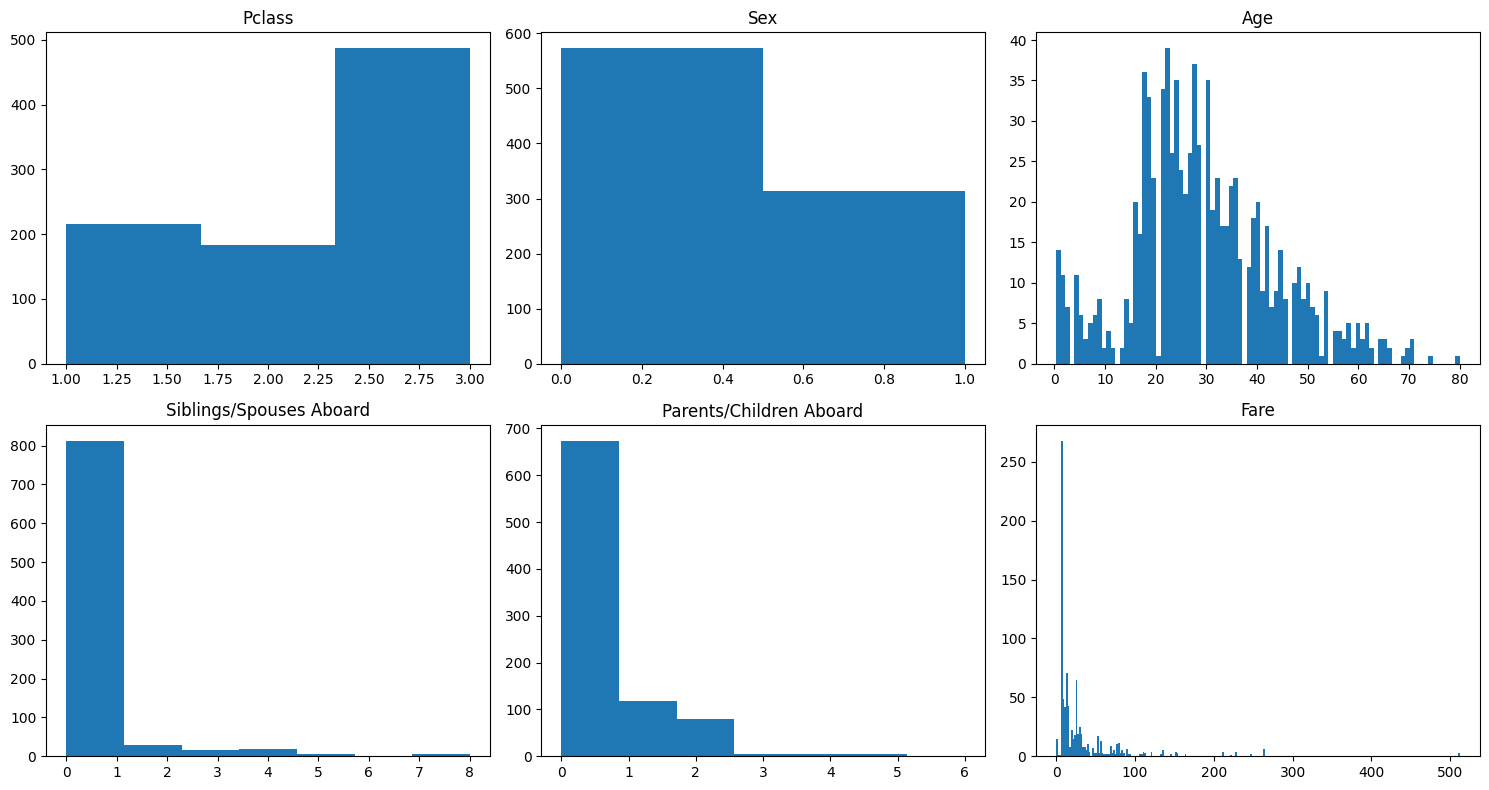

     Pclass       Sex       Age  Siblings/Spouses Aboard  \
0  0.830055 -0.739848 -0.529068                 0.429662   
1 -1.560396  1.350105  0.603924                 0.429662   
2  0.830055  1.350105 -0.245820                -0.475587   
3 -1.560396  1.350105  0.391488                 0.429662   
4  0.830055 -0.739848  0.391488                -0.475587   

   Parents/Children Aboard      Fare  
0                -0.474713 -0.503302  
1                -0.474713  0.782971  
2                -0.474713 -0.489743  
3                -0.474713  0.417712  
4                -0.474713 -0.487232  


In [2]:
# display feature statistics
displayFeatureStatastics(X)
# normalize dataset
X, standard_mean, standard_std = NN.normalize(X)
print(X.head())

First, zero-mean normalization is performed on all features, because different features have different numerical ranges, which will cause a certain feature to have a particularly large impact on the final distance calculation (such as **Fare**). Therefore, zero-mean normalization is used to eliminate the magnitude influence between features.  
For continuous features, there is no doubt that Euclidean distance is used to calculate the distance between two samples.   
There are two discrete features left: "Pclass" and "Sex".  
For the feature **Sex**, it follows the Bernoulli distribution, so the results measured using Hamming distance and Euclidean distance are the same. Hamming distance is the number of locations where the corresponding feature values of two samples are different. If the feature categories are the same, the distance is 0. If the categories are different, the distance between the features of the two samples is 1. And when the categories are the same, the Euclidean distance is also 0, and when the categories are different, the Euclidean distance is also 1.  
For the feature **Pclass**, it has three value categories (1, 2, 3). It should be noted that these three categories show a progressive relationship, that is, the distance between category 1 and category 3 should be larger than the distance between category 2 and category 3. Therefore for this feature, the Euclidean distance measure is also used.  
In summary, all characteristics of a sample can be measured using Euclidean distance. Therefore calculate the distance between two feature vectors using Euclidean distance directly.


# Problem 5.1 (c)

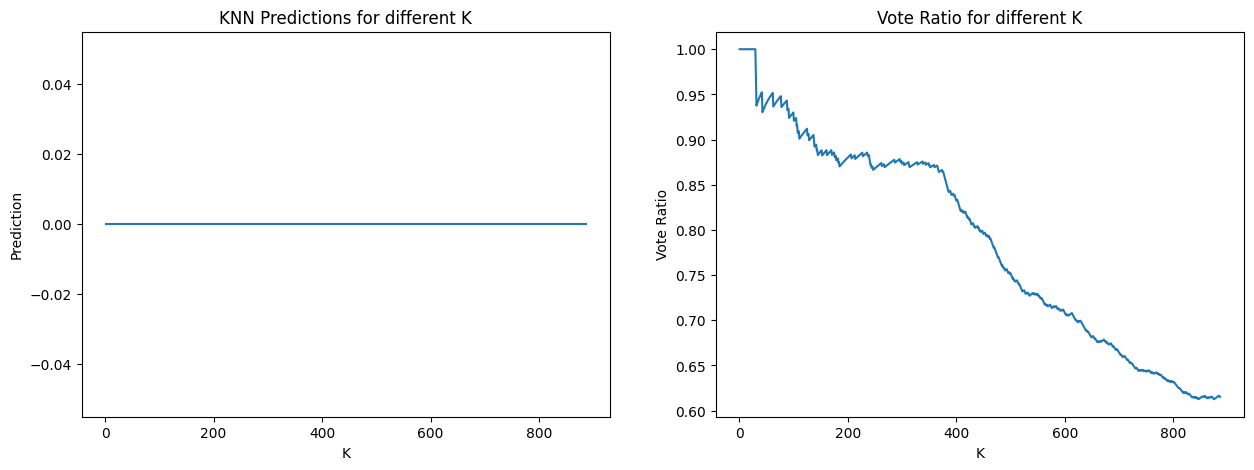

Best K = 30


In [3]:
# predict my feature vector
new_x = pd.Series({'Pclass': 3, 'Sex': 0, 'Age': 23, 'Siblings/Spouses Aboard': 0, 'Parents/Children Aboard': 0, 'Fare': 7.75})
# normalize new_x
for feature in X:
    new_x[feature] = (new_x[feature] - standard_mean[feature]) / standard_std[feature]

# predict
best_k = NN.predict(X, y, new_x)
print(f'Best K = {best_k}')

For $K = 1,2,......,N$, the predictions are all $0$, which means the results are all **Deceased**.

# Problem 5.1 (d)

In light of the prediction results of problem 5.1(c), the best choice of K is 30. Because when K=30, the category that the model predicts has the highest proportion of votes, that is, the proportion that the number of same-category neighbors divided by the total number of neighbors is the largest. So it has the highest confidence. In addition, K=30 is not too small and has a certain degree of robustness in the face of noise.

# Problem 5.1 (e)

In [4]:
# assess the performance of KNN
avg_accuracy, avg_precision, avg_recall = NN.crossValidation(NN.splitKFold(X, y), best_k)
print(f"Cross Validation for KNN with k={best_k}")
print(f'avg_accuracy = {avg_accuracy}, avg_precision = {avg_precision}, avg_recall = {avg_recall}')

Cross Validation for KNN with k=30
avg_accuracy = 0.8204904306220095, avg_precision = 0.7867344568115893, avg_recall = 0.7263825712471222


I use cross-validation (k=10) to assess the reliability of the model when taking the best K, and the results show that  
$$accuracy = 0.8204904306220095,\quad precision = 0.7867344568115893,\quad recall = 0.7263825712471222$$

# Problem 5.2 (a)

In [5]:
class NaiveBayes:
    def __init__(self):
        self.bernoulli_and_multinomial_features = ['Pclass', 'Sex']
        self.poisson_features = ['Siblings/Spouses Aboard', 'Parents/Children Aboard']
        self.exponential_features = ['Fare']
        self.gaussian_features = ['Age']

    def loadData(self):
        # read data
        df = pd.read_csv('titanic_data.csv')
        # split features and label
        X = df.drop(['Survived'], axis=1)
        y = df['Survived']

        return X, y
       
    def mle_prob(self, X, y, new_x, feature, label):
        # poisson probability density function
        def poisson(x, mean):
            return (mean**x * np.exp(-mean)) / math.factorial(int(x))
        
        # exponential probability density function
        def exponential(x, mean):
            return (1 / mean) * np.exp(-x / mean)
        
        # guassian probability density function
        def guassian(x, mean, std):
            return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
        
        cond_prob = 0
        index = y[y == label].index
        # calculate conditional probability
        if feature in self.poisson_features:
            mean = X.loc[index][feature].mean()
            cond_prob = poisson(new_x[feature], mean)
        elif feature in self.exponential_features:
            mean = X.loc[index][feature].mean()
            cond_prob = exponential(new_x[feature], mean)
        elif feature in self.gaussian_features:
            mean = X.loc[index][feature].mean()
            std = X.loc[index][feature].std()
            cond_prob = guassian(new_x[feature], mean, std)
        elif feature in self.bernoulli_and_multinomial_features:
            # laplace smoothing
            cond_prob += 1
            for i in range(len(X)):
                if y.iloc[i] == label and X.iloc[i][feature] == new_x[feature]:
                    cond_prob += 1
            cond_prob /= (y.value_counts()[label] + X[feature].nunique())

        return cond_prob
    
    
    def predict(self, X, y, new_x):
        # predict
        post_prob_dict = {}

        # calculate prior
        prior_prob_series = y.value_counts() / len(y)
        for label in prior_prob_series.keys():
            prior_prob = prior_prob_series[label]
            # calculate conditional probability
            cond_prob = 1
            for feature in X:
                cond_prob *= self.mle_prob(X, y, new_x, feature, label)
            
            # calculate posterior probability
            post_prob = prior_prob * cond_prob

            post_prob_dict[label] = post_prob

        prediciton = max(post_prob_dict, key=post_prob_dict.get)
        return prediciton, post_prob_dict
    
    def splitKFold(self, X, y, k=10):
        fold_size = len(X) // k
        kfolds = []
        for i in range(k):
            start = i * fold_size
            end = len(X) if i == k-1 else (i + 1) * fold_size
            X_test = X.iloc[start:end]
            y_test = y.iloc[start:end]
            X_train = X.drop(X.index[start:end])
            y_train = y.drop(y.index[start:end])
            kfolds.append((X_train, y_train, X_test, y_test))

        return kfolds
        
    def crossValidation(self, kfolds):
        k = len(kfolds)
        accuracy, precision, recall = 0, 0, 0
        for i in range(k):
            X_train, y_train, X_test, y_test = kfolds[i]
            # test
            tp, fp, tn, fn = 0, 0, 0, 0
            for j in range(len(X_test)):
                prediction, _ = self.predict(X_train, y_train, X_test.iloc[j])
                if prediction == 1 and y_test.iloc[j] == 1:
                    tp += 1
                elif prediction == 1 and y_test.iloc[j] == 0:
                    fp += 1
                elif prediction == 0 and y_test.iloc[j] == 1:
                    fn += 1
                else:
                    tn += 1
            accuracy += (tp + tn) / len(X_test)
            precision += tp / (tp + fp) if tp + fp > 0 else 0
            recall += tp / (tp + fn) if tp + fn > 0 else 0
            print(f'Fold {i}: accuracy = {(tp + tn) / len(X_test)}, precision = {tp / (tp + fp) if tp + fp > 0 else 0}, recall = {tp / (tp + fn) if tp + fn > 0 else 0}')
        
        avg_accuracy = accuracy / k
        avg_precision = precision / k
        avg_recall = recall / k

        return avg_accuracy, avg_precision, avg_recall  



# Naive Bayes
NB = NaiveBayes()
X, y = NB.loadData()

# Problem 5.2 (b)

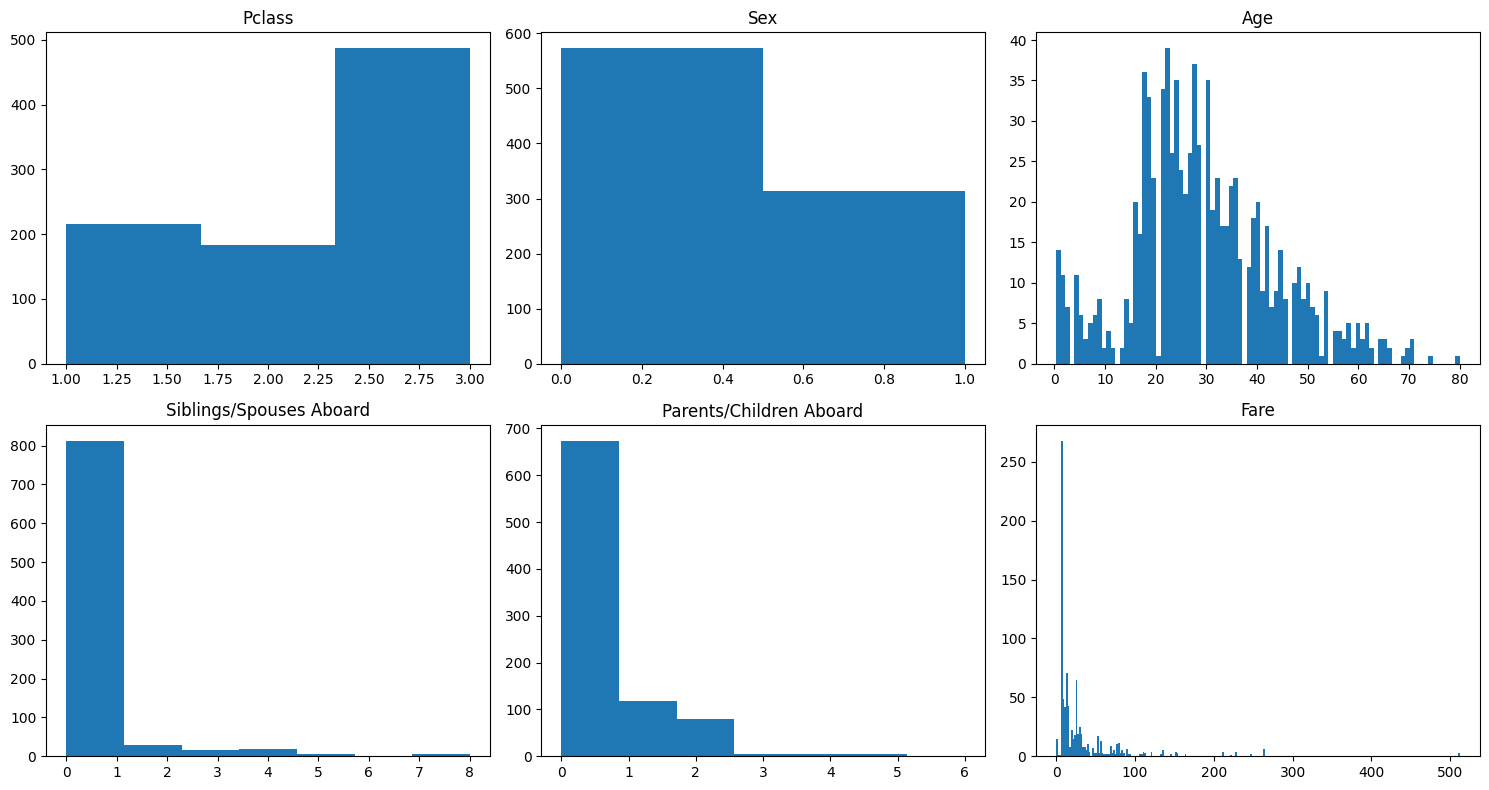

In [6]:
# display feature statistics
displayFeatureStatastics(X)

For the feature **Pclass**, the value of each sample is one of (1, 2, 3), which conforms to the **Multinomial** distribution.  
For the features **Siblings/Spouses Aboard** and **Parents/Children Aboard**, they are both discrete variables and present an unimodal shape. And most of the data are concentrated on smaller values, so they are modeled using the **Poisson** distribution.  
For the feature **Sex**, the value of each sample can only be one of 0 and 1, so it is a **Bernoulli** distribution.  
For the feature **Fare**, it also presents an unimodal shape, and most data are concentrated on smaller values, but it is a continuous variable, so it is modeled using an **Exponential** distribution.  
For the feature **Age**, it is a continuous variable whose shape generally conforms to the Gaussian distribution, so it is modeled using the **Gaussian** distribution.

# Problem 5.2 (c)

In [7]:
# predict my feature vector
new_x = pd.Series({'Pclass': 3, 'Sex': 0, 'Age': 23, 'Siblings/Spouses Aboard': 0, 'Parents/Children Aboard': 0, 'Fare': 7.75})
prediction, post_prob_dict = NB.predict(X, y, new_x)
result = 'Survived' if prediction == 1 else 'Deceased'
print(f'post_prob_dict = {post_prob_dict}, prediction = {prediction}->{result}')

post_prob_dict = {0: 0.00011542235796519182, 1: 7.612281280269399e-06}, prediction = 0->Deceased


# Problem 5.2 (d)

In [8]:
# cross validation
avg_accuracy, avg_precision, avg_recall = NB.crossValidation(NB.splitKFold(X, y))
print("Cross Validation for Naive Bayes")
print(f'avg_accuracy = {avg_accuracy}, avg_precision = {avg_precision}, avg_recall = {avg_recall}')

Fold 0: accuracy = 0.6818181818181818, precision = 0.72, recall = 0.46153846153846156
Fold 1: accuracy = 0.7613636363636364, precision = 0.47619047619047616, recall = 0.5
Fold 2: accuracy = 0.7386363636363636, precision = 0.6923076923076923, recall = 0.5454545454545454
Fold 3: accuracy = 0.7727272727272727, precision = 0.8787878787878788, recall = 0.6444444444444445
Fold 4: accuracy = 0.7386363636363636, precision = 0.6875, recall = 0.6285714285714286
Fold 5: accuracy = 0.8295454545454546, precision = 0.8518518518518519, recall = 0.6764705882352942
Fold 6: accuracy = 0.75, precision = 0.7666666666666667, recall = 0.6052631578947368
Fold 7: accuracy = 0.7386363636363636, precision = 0.6521739130434783, recall = 0.5
Fold 8: accuracy = 0.7840909090909091, precision = 0.76, recall = 0.59375
Fold 9: accuracy = 0.7789473684210526, precision = 0.7586206896551724, recall = 0.6111111111111112
Cross Validation for Naive Bayes
avg_accuracy = 0.7574401913875597, avg_precision = 0.7244099168503216,

I use cross-validation (k=10) to assess the reliability of the Naive Bayes model, and the results show that  
$$accuracy = 0.7574401913875597,\quad precision = 0.7244099168503216,\quad recall = 0.5766603737250022$$

# Problem 5.3

So far, the predictions of my all models (Logistic Regression model, Decision Tree model, Random Forest, KNN, Naive Bayes) are all **Deceased**.   
I prefer the logistic regression model because:  
1. The accuracy of my logistic regression model is one of the highest $0.82$, which is higher than the cross-validation accuracy of the decision tree ($0.807$), random forest ($0.796$ && $0.795$), Naive Bayes ($0.75$), and the same as the KNN ($0.82$).  
2. By calculating the confidence interval, the logistic regression model will provide a reliable probability of the predicted outcome. In this problem of predicting the survival of the Titanic, the result of the logistic regression model is reliable with a 95% probability. But for other models (Decision Tree, Random Forest, Naive Bayes, KNN), we can only use the cross-validation to get an overall accuracy.  
3. The logistic regression model is more computationally efficient.
4. The Naive Bayes is under the naive assumption that features are independent, but this assumption sometimes is not correct.
5. The KNN algorithm does not have a specific model. It only makes predictions through the neighbors of the sample and does not provide much insight into the problem domain.

# Problem 5.4

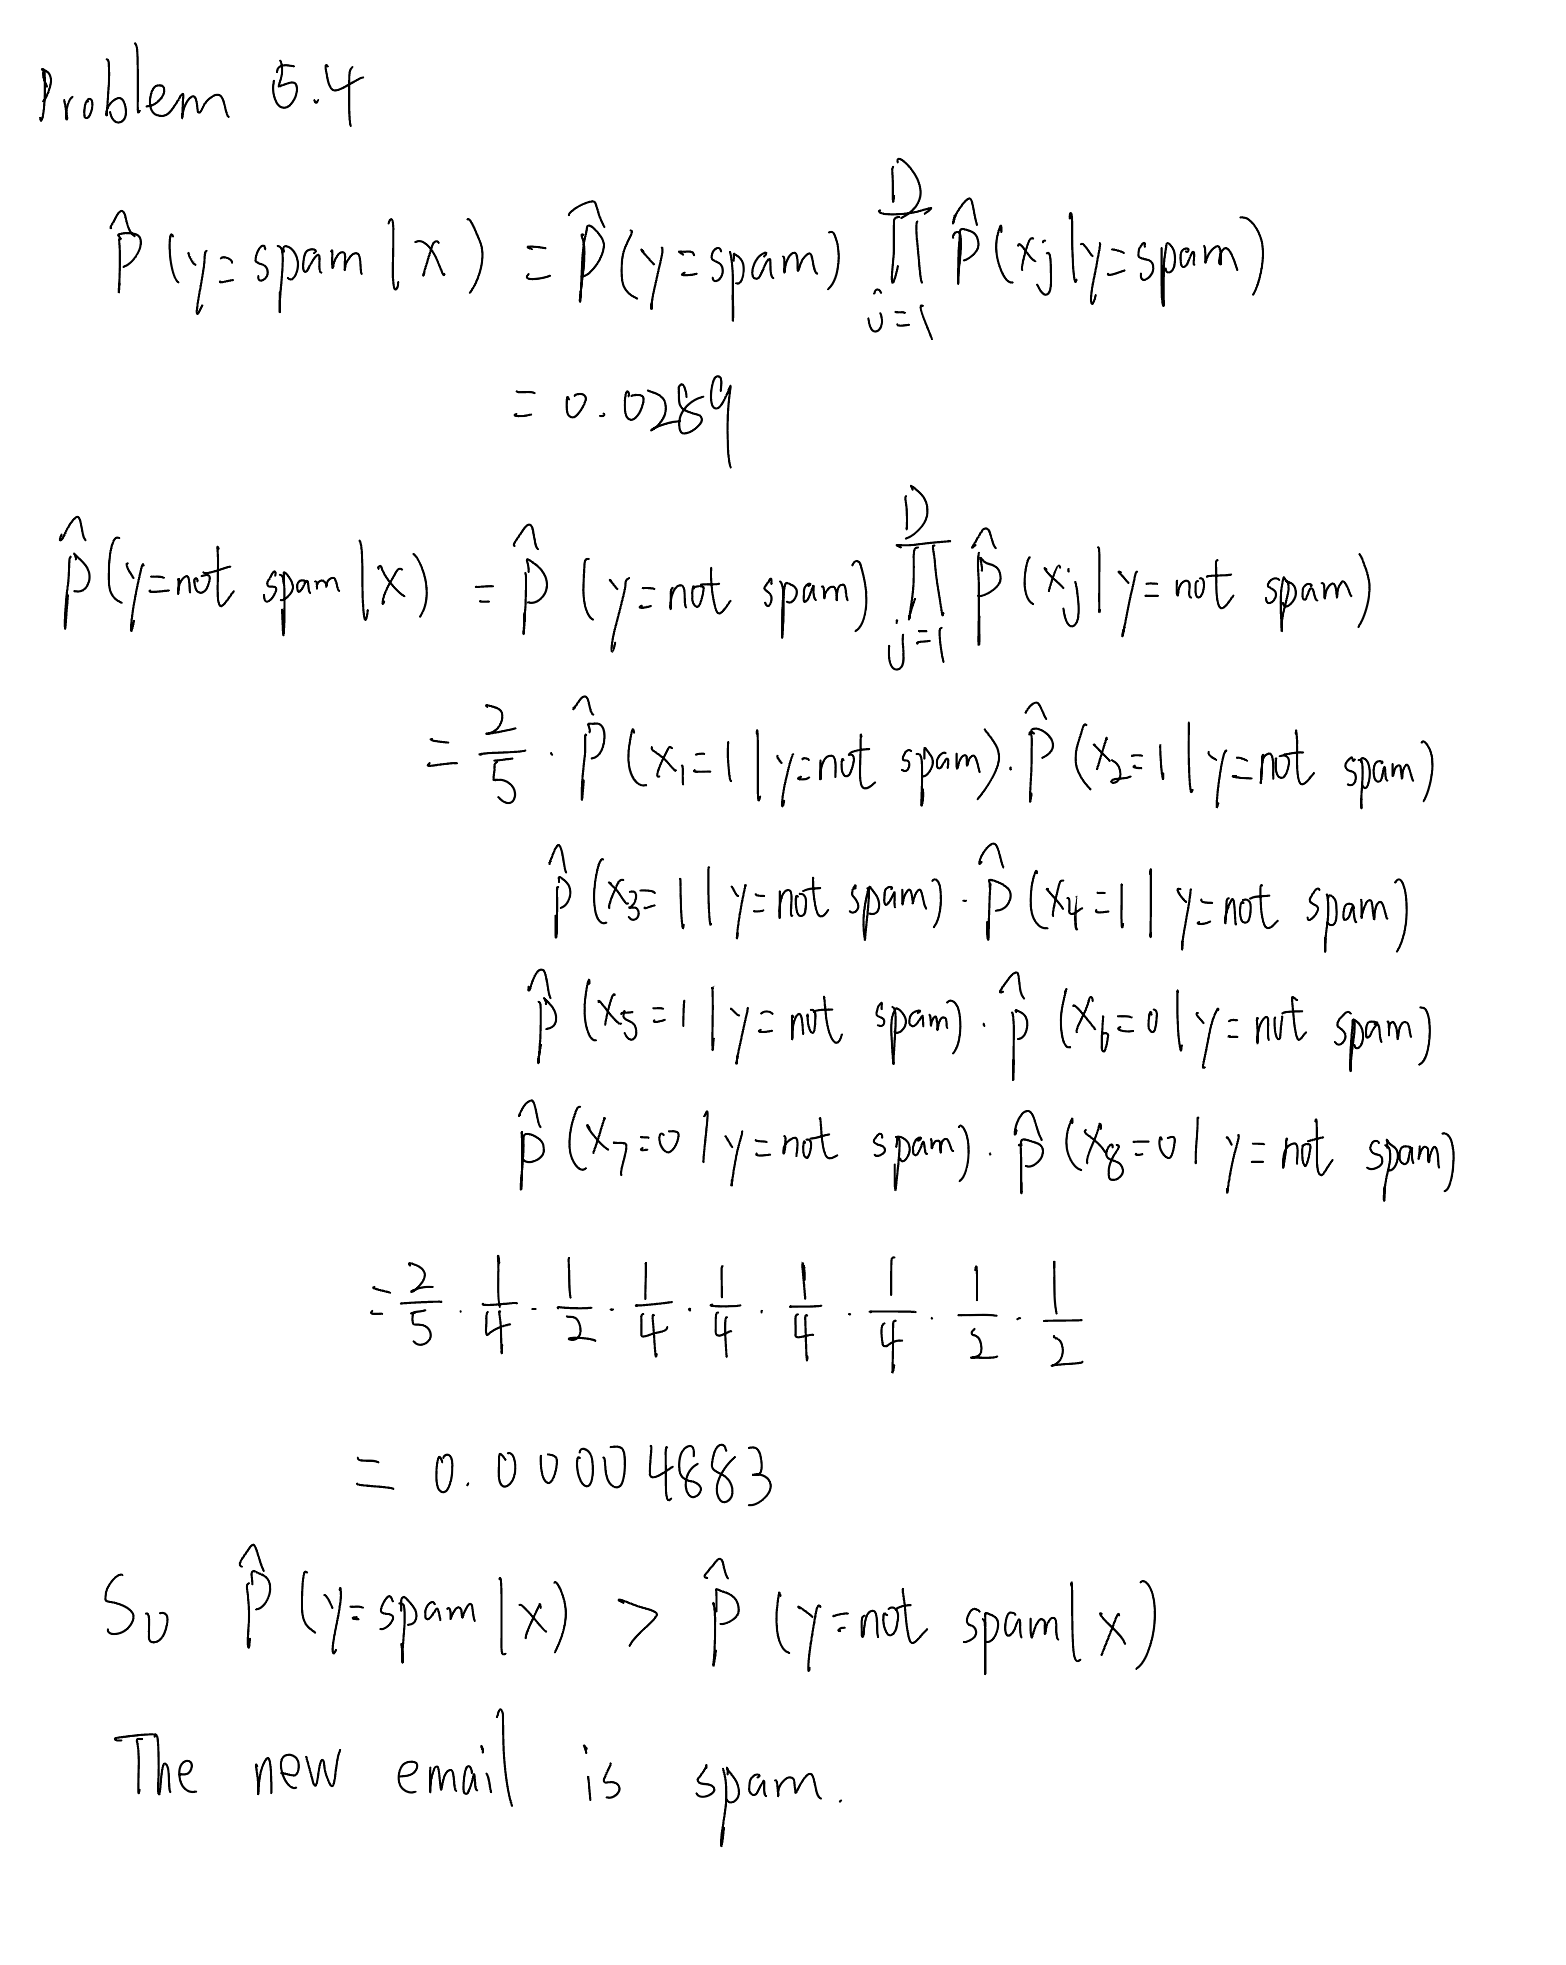

# Problem 5.5

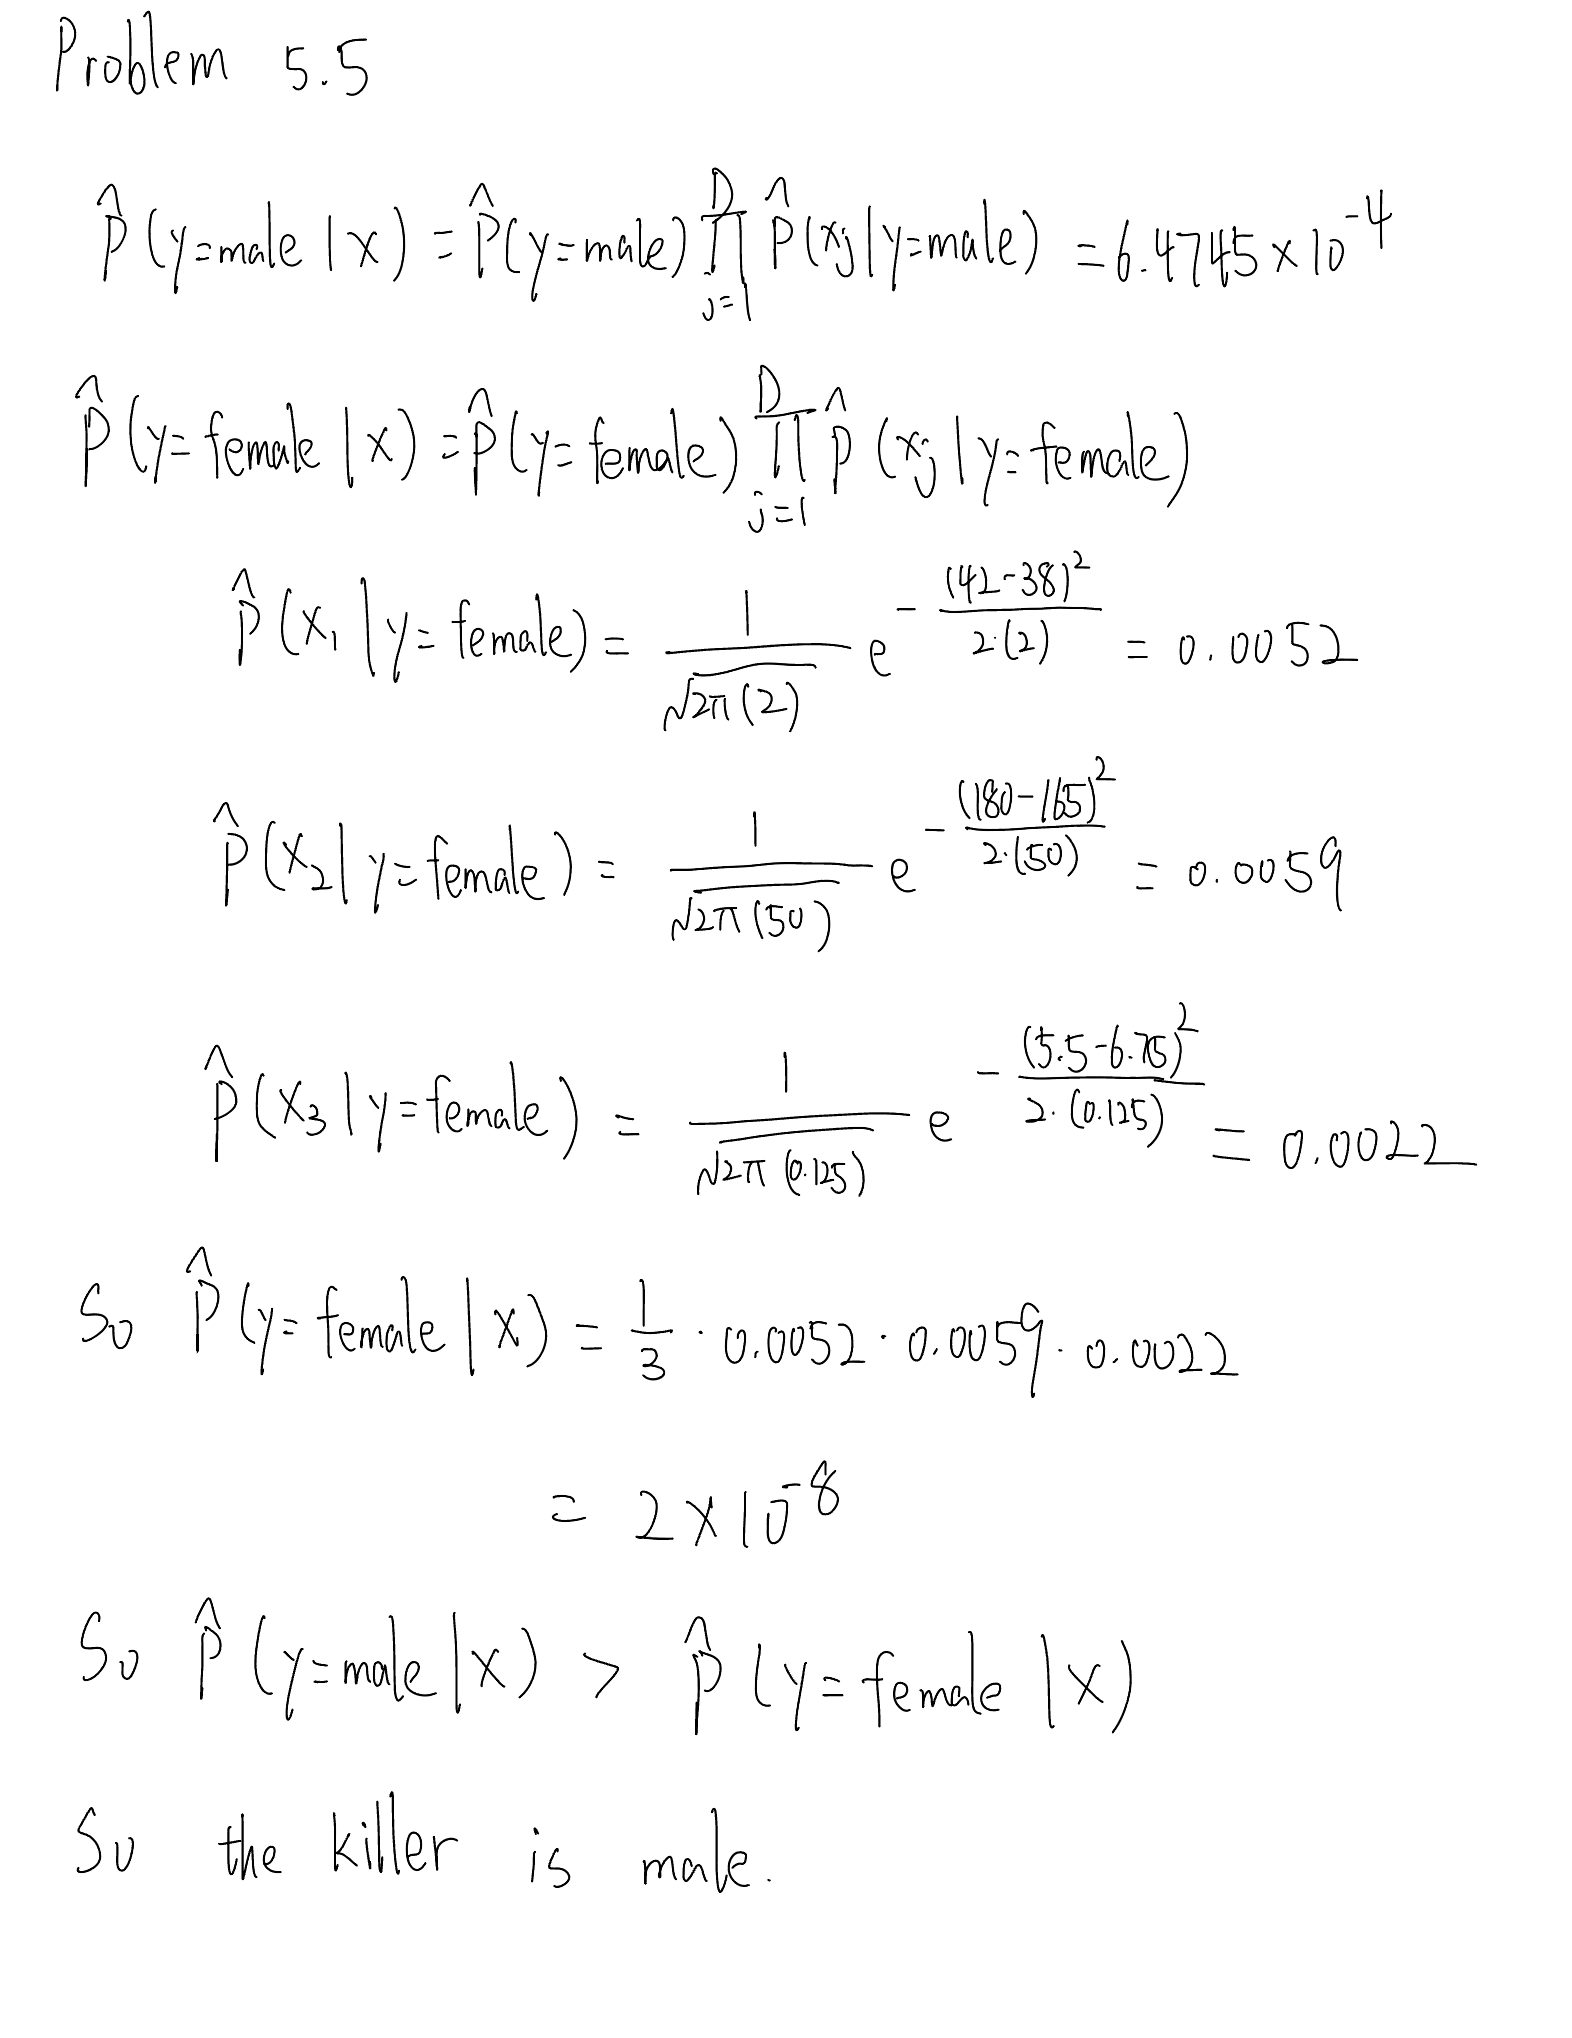

# Appendix

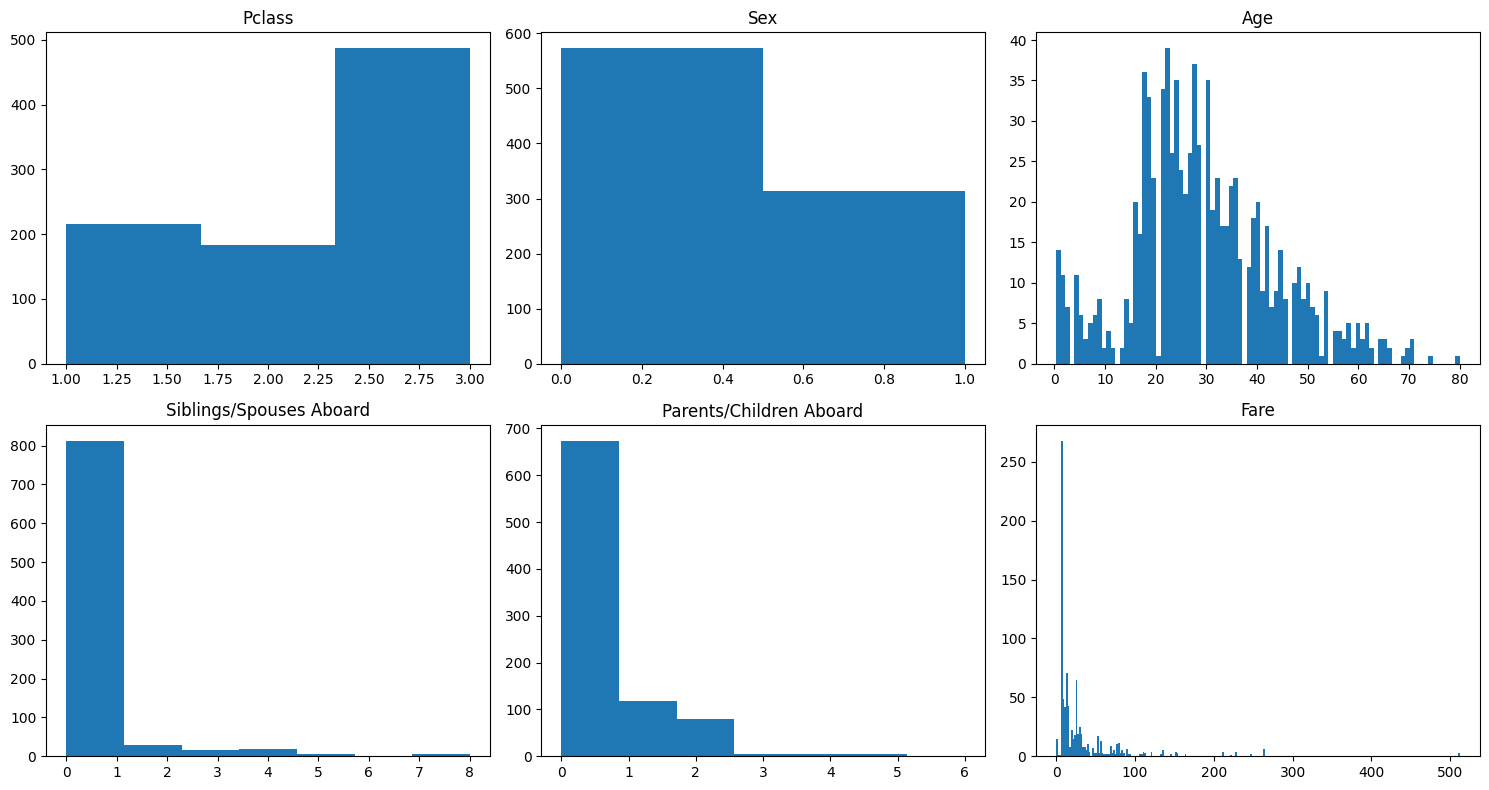

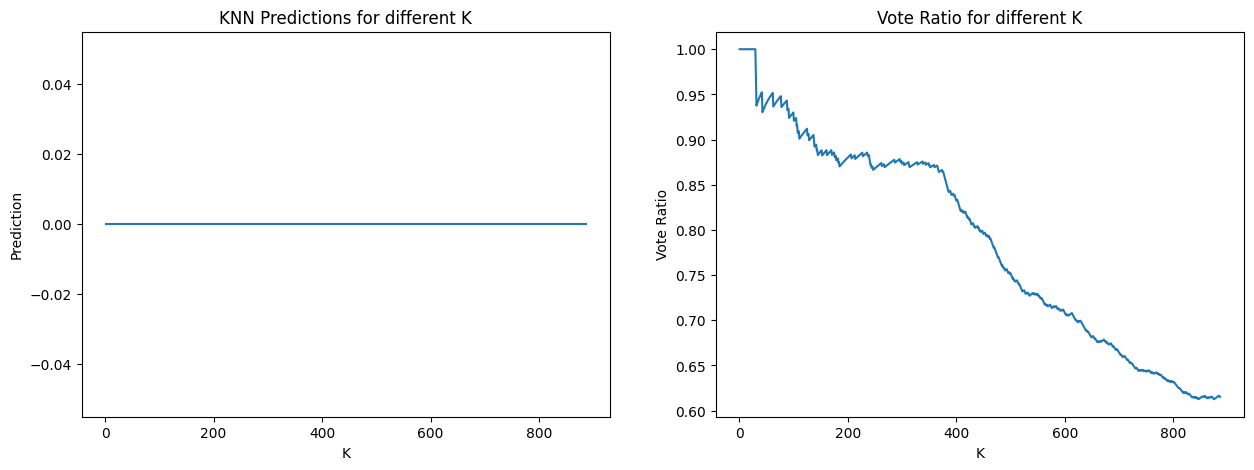

Best K = 30
Cross Validation for KNN with k=30
avg_accuracy = 0.8204904306220095, avg_precision = 0.7867344568115893, avg_recall = 0.7263825712471222
----------------------------------------------
post_prob_dict = {0: 0.00011542235796519182, 1: 7.612281280269399e-06}, prediction = 0->Deceased
Fold 0: accuracy = 0.6818181818181818, precision = 0.72, recall = 0.46153846153846156
Fold 1: accuracy = 0.7613636363636364, precision = 0.47619047619047616, recall = 0.5
Fold 2: accuracy = 0.7386363636363636, precision = 0.6923076923076923, recall = 0.5454545454545454
Fold 3: accuracy = 0.7727272727272727, precision = 0.8787878787878788, recall = 0.6444444444444445
Fold 4: accuracy = 0.7386363636363636, precision = 0.6875, recall = 0.6285714285714286
Fold 5: accuracy = 0.8295454545454546, precision = 0.8518518518518519, recall = 0.6764705882352942
Fold 6: accuracy = 0.75, precision = 0.7666666666666667, recall = 0.6052631578947368
Fold 7: accuracy = 0.7386363636363636, precision = 0.6521739130434

In [9]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

def displayFeatureStatastics(X):
    _, ax = plt.subplots(2, 3, figsize=(15, 8))
    for i, feature in enumerate(X):
        ax[i//3, i%3].hist(X[feature], bins=len(X[feature].value_counts()))
        ax[i//3, i%3].set_title(feature)

    plt.tight_layout()
    plt.show()

class NearestNeighbor:
    def __init__(self):
        pass

    def loadData(self):
        # read data
        df = pd.read_csv('titanic_data.csv')
        # split features and label
        X = df.drop(['Survived'], axis=1)
        y = df['Survived']

        return X, y

    def normalize(self, X):
        standard_mean = {}
        standard_std = {}
        # normalize data
        for feature in X:
            standard_mean[feature] = X[feature].mean()
            standard_std[feature] = X[feature].std()
            X[feature] = (X[feature] - X[feature].mean()) / X[feature].std()

        return X, pd.Series(standard_mean), pd.Series(standard_std)

    def distance(self, x1, x2):
        dist = 0
        for feature in x1.keys():
            dist += (x1[feature] - x2[feature])**2
        dist = np.sqrt(dist)   

        return dist

    def KNN(self, X, y, new_x, k):
        # calculate distances
        dist_series = X.apply(lambda x: self.distance(x, new_x), axis=1)
        knn_index = dist_series.nsmallest(k).index
        vote = y[knn_index].value_counts()
        return vote

    def predict(self, X, y, new_x):
        # predict
        predictions = []
        vote_ratio = []
        best_k = 0
        max_vote_ratio = 0
        for k in range(1, len(X)):
            vote = self.KNN(X, y, new_x, k)
            ratio = vote.iloc[0] / k
            if ratio >= max_vote_ratio:
                max_vote_ratio = ratio
                best_k = k
            vote_ratio.append(ratio)
            # save prediction
            prediction = vote.keys()[0]
            predictions.append(prediction)

        x = range(1, len(X))
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        # plot predictions
        ax[0].plot(x, predictions)
        ax[0].set_xlabel('K')
        ax[0].set_ylabel('Prediction')
        ax[0].set_title('KNN Predictions for different K')
        # plot vote ratio
        ax[1].plot(x, vote_ratio)
        ax[1].set_xlabel('K')
        ax[1].set_ylabel('Vote Ratio')
        ax[1].set_title('Vote Ratio for different K')

        plt.show()

        return best_k

    def splitKFold(self, X, y, nfolds=10):
        fold_size = len(X) // nfolds
        kfolds = []
        for i in range(nfolds):
            start = i * fold_size
            end = len(X) if i == nfolds-1 else (i + 1) * fold_size
            X_test = X.iloc[start:end]
            y_test = y.iloc[start:end]
            X_train = X.drop(X.index[start:end])
            y_train = y.drop(y.index[start:end])
            kfolds.append((X_train, y_train, X_test, y_test))

        return kfolds
        
    def crossValidation(self, kfolds, k):
        nfolds = len(kfolds)
        accuracy, precision, recall = 0, 0, 0
        for i in range(nfolds):
            X_train, y_train, X_test, y_test = kfolds[i]
            # test
            tp, fp, tn, fn = 0, 0, 0, 0
            for j in range(len(X_test)):
                vote = self.KNN(X_train, y_train, X_test.iloc[j], k)
                prediction = vote.keys()[0]
                if prediction == 1 and y_test.iloc[j] == 1:
                    tp += 1
                elif prediction == 1 and y_test.iloc[j] == 0:
                    fp += 1
                elif prediction == 0 and y_test.iloc[j] == 1:
                    fn += 1
                else:
                    tn += 1
            accuracy += (tp + tn) / len(X_test)
            precision += tp / (tp + fp) if tp + fp > 0 else 0
            recall += tp / (tp + fn) if tp + fn > 0 else 0
        
        avg_accuracy = accuracy / nfolds
        avg_precision = precision / nfolds
        avg_recall = recall / nfolds

        return avg_accuracy, avg_precision, avg_recall
          

class NaiveBayes:
    def __init__(self):
        self.bernoulli_and_multinomial_features = ['Pclass', 'Sex']
        self.poisson_features = ['Siblings/Spouses Aboard', 'Parents/Children Aboard']
        self.exponential_features = ['Fare']
        self.gaussian_features = ['Age']

    def loadData(self):
        # read data
        df = pd.read_csv('titanic_data.csv')
        # split features and label
        X = df.drop(['Survived'], axis=1)
        y = df['Survived']

        return X, y
       
    def mle_prob(self, X, y, new_x, feature, label):
        # poisson probability density function
        def poisson(x, mean):
            return (mean**x * np.exp(-mean)) / math.factorial(int(x))
        
        # exponential probability density function
        def exponential(x, mean):
            return (1 / mean) * np.exp(-x / mean)
        
        # guassian probability density function
        def guassian(x, mean, std):
            return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std)**2)
        
        cond_prob = 0
        index = y[y == label].index
        # calculate conditional probability
        if feature in self.poisson_features:
            mean = X.loc[index][feature].mean()
            cond_prob = poisson(new_x[feature], mean)
        elif feature in self.exponential_features:
            mean = X.loc[index][feature].mean()
            cond_prob = exponential(new_x[feature], mean)
        elif feature in self.gaussian_features:
            mean = X.loc[index][feature].mean()
            std = X.loc[index][feature].std()
            cond_prob = guassian(new_x[feature], mean, std)
        elif feature in self.bernoulli_and_multinomial_features:
            # laplace smoothing
            cond_prob += 1
            for i in range(len(X)):
                if y.iloc[i] == label and X.iloc[i][feature] == new_x[feature]:
                    cond_prob += 1
            cond_prob /= (y.value_counts()[label] + X[feature].nunique())

        return cond_prob
    
    
    def predict(self, X, y, new_x):
        # predict
        post_prob_dict = {}

        # calculate prior
        prior_prob_series = y.value_counts() / len(y)
        for label in prior_prob_series.keys():
            prior_prob = prior_prob_series[label]
            # calculate conditional probability
            cond_prob = 1
            for feature in X:
                cond_prob *= self.mle_prob(X, y, new_x, feature, label)
            
            # calculate posterior probability
            post_prob = prior_prob * cond_prob

            post_prob_dict[label] = post_prob

        prediciton = max(post_prob_dict, key=post_prob_dict.get)
        return prediciton, post_prob_dict
    
    def splitKFold(self, X, y, k=10):
        fold_size = len(X) // k
        kfolds = []
        for i in range(k):
            start = i * fold_size
            end = len(X) if i == k-1 else (i + 1) * fold_size
            X_test = X.iloc[start:end]
            y_test = y.iloc[start:end]
            X_train = X.drop(X.index[start:end])
            y_train = y.drop(y.index[start:end])
            kfolds.append((X_train, y_train, X_test, y_test))

        return kfolds
        
    def crossValidation(self, kfolds):
        k = len(kfolds)
        accuracy, precision, recall = 0, 0, 0
        for i in range(k):
            X_train, y_train, X_test, y_test = kfolds[i]
            # test
            tp, fp, tn, fn = 0, 0, 0, 0
            for j in range(len(X_test)):
                prediction, _ = self.predict(X_train, y_train, X_test.iloc[j])
                if prediction == 1 and y_test.iloc[j] == 1:
                    tp += 1
                elif prediction == 1 and y_test.iloc[j] == 0:
                    fp += 1
                elif prediction == 0 and y_test.iloc[j] == 1:
                    fn += 1
                else:
                    tn += 1
            accuracy += (tp + tn) / len(X_test)
            precision += tp / (tp + fp) if tp + fp > 0 else 0
            recall += tp / (tp + fn) if tp + fn > 0 else 0
            print(f'Fold {i}: accuracy = {(tp + tn) / len(X_test)}, precision = {tp / (tp + fp) if tp + fp > 0 else 0}, recall = {tp / (tp + fn) if tp + fn > 0 else 0}')
        
        avg_accuracy = accuracy / k
        avg_precision = precision / k
        avg_recall = recall / k

        return avg_accuracy, avg_precision, avg_recall  


if __name__ == '__main__':
    # Nearest Neighbor
    NN = NearestNeighbor()
    X, y = NN.loadData()
    # display feature statistics
    displayFeatureStatastics(X)
    # normalize dataset
    X, standard_mean, standard_std = NN.normalize(X)
    
    # predict my feature vector
    new_x = pd.Series({'Pclass': 3, 'Sex': 0, 'Age': 23, 'Siblings/Spouses Aboard': 0, 'Parents/Children Aboard': 0, 'Fare': 7.75})
    # normalize new_x
    for feature in X:
        new_x[feature] = (new_x[feature] - standard_mean[feature]) / standard_std[feature]
    
    # predict
    best_k = NN.predict(X, y, new_x)
    print(f'Best K = {best_k}')

    # assess the performance of KNN
    avg_accuracy, avg_precision, avg_recall = NN.crossValidation(NN.splitKFold(X, y), best_k)
    print(f"Cross Validation for KNN with k={best_k}")
    print(f'avg_accuracy = {avg_accuracy}, avg_precision = {avg_precision}, avg_recall = {avg_recall}')

    # ----------------------------------------------
    print('----------------------------------------------')
    # Naive Bayes
    NB = NaiveBayes()
    X, y = NB.loadData()

    # predict my feature vector
    new_x = pd.Series({'Pclass': 3, 'Sex': 0, 'Age': 23, 'Siblings/Spouses Aboard': 0, 'Parents/Children Aboard': 0, 'Fare': 7.75})
    prediction, post_prob_dict = NB.predict(X, y, new_x)
    result = 'Survived' if prediction == 1 else 'Deceased'
    print(f'post_prob_dict = {post_prob_dict}, prediction = {prediction}->{result}')

    # cross validation
    avg_accuracy, avg_precision, avg_recall = NB.crossValidation(NB.splitKFold(X, y))
    print("Cross Validation for Naive Bayes")
    print(f'avg_accuracy = {avg_accuracy}, avg_precision = {avg_precision}, avg_recall = {avg_recall}')

